### Geospatial Analysis: Medically Underserved Areas based on Zip Code (Multi-Class CNN Model)

**1. Data was first pre-processed and load the final version of la_facility_mua.csv here**

**2. Since feature engineering has been done, a few touch-ups before training:** 

a) Feature Mapping,

b) Dropping useless variables, 

c) Regex applications, 

d) Days Diff

**3. Data was split into Train and Validation**

**4. Model: Multi-Class CNN with Tensorflow.Keras (Zip Code: 51 classes)**

**5. The best model with Train Loss: 0.1499 - Train Accuracy: 0.9335, Val Loss: 0.1008 - Val Accuracy: 0.9673**

In [2]:
import os
os.environ['PYTHONHASHSEED']='0'

In [3]:
import random as rn
# Deep Learning Libraries
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.layers import Conv1D,MaxPool1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import callbacks
import tensorflow as tf
np.random.seed(37)
tf.random.set_seed(42)
from keras import backend as K

Using TensorFlow backend.


In [4]:
#1
import pandas as pd
import numpy as np
import seaborn as sns
import re
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.gridspec as gridspec
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import auc,roc_auc_score
from catboost import CatBoostClassifier,Pool, cv
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold

la_facility_mua = pd.read_csv('../input/la-final-data-2/la_facility_mua.csv')

In [5]:
#2
la_facility_mua.head(6)

,source,cat1,cat2,org_name,Name,addrln1,city,state,post_id,description,...,facility_address_1,MUA_RuralStatus,MUA_Designated_Time,MUA_Designated_Date,MUA_MSSA_Name_1,MUA_Updated_Time,MUA_Updated_Date,MUA_Poverty,MUA_Score,MUA_Pct_100Poverty
0,211,Social Services,Children and Family Services,neweconomicsforwomen.org,New Economics For Women - Familysource Center ...,501 S. Bixel St.,Los Angeles,CA,56652,The agency is an economic development organiza...,...,415 South Union Avenue,Urban,1.067990e+12,2003-11-05,MSSA 78.2b (Pico Union/Westlake),1.067990e+12,2003-11-05,157757.0,51.0,0.0
1,211,Social Services,Children and Family Services,neweconomicsforwomen.org,New Economics For Women - Familysource Center ...,501 S. Bixel St.,Los Angeles,CA,56652,The agency is an economic development organiza...,...,600 St Paul Ave,Urban,7.686144e+11,1994-05-11,Westlake Service Area,1.005782e+12,2001-11-15,0.0,60.1,0.0
2,211,Social Services,Children and Family Services,neweconomicsforwomen.org,New Economics For Women - Familysource Center ...,501 S. Bixel St.,Los Angeles,CA,56652,The agency is an economic development organiza...,...,1125 W 6th St,Urban,7.686144e+11,1994-05-11,Westlake Service Area,1.005782e+12,2001-11-15,0.0,60.1,0.0
3,211,Social Services,Children and Family Services,neweconomicsforwomen.org,New Economics For Women - Familysource Center ...,501 S. Bixel St.,Los Angeles,CA,56652,The agency is an economic development organiza...,...,1225 Wilshire Boulevard,Urban,7.686144e+11,1994-05-11,Westlake Service Area,1.005782e+12,2001-11-15,0.0,60.1,0.0
4,211,Social Services,Children and Family Services,neweconomicsforwomen.org,New Economics For Women - Familysource Center ...,501 S. Bixel St.,Los Angeles,CA,56652,The agency is an economic development organiza...,...,1127 Wilshire Blvd,Urban,7.686144e+11,1994-05-11,Westlake Service Area,1.005782e+12,2001-11-15,0.0,60.1,0.0
5,211,Social Services,Children and Family Services,neweconomicsforwomen.org,New Economics For Women - Familysource Center ...,501 S. Bixel St.,Los Angeles,CA,56652,The agency is an economic development organiza...,...,1212 Wilshire Blvd,Urban,7.686144e+11,1994-05-11,Westlake Service Area,1.005782e+12,2001-11-15,0.0,60.1,0.0


In [6]:
#3
la_facility_mua=la_facility_mua[la_facility_mua['MUA_Designated_Time'].notnull()]
la_facility_mua.drop(['facility_number_of_beds', 'facility_name', 'org_name', 'Name'],
                    axis=1, inplace=True)
la_facility_mua= la_facility_mua[la_facility_mua['Zip Code']!=0.0]
la_facility_mua['Zip Code']=la_facility_mua['Zip Code'].astype('int64')

In [10]:
#4
la_facility_mua['facility_er_service'] = la_facility_mua['facility_er_service'].map({
'Not Applicable':'Not Applicable',
'None':'Not Applicable',
'Emergency - Basic':'Emergency',
'Emergency - Comprehensive':'Emergency',
'Emergency - Standby':'Emergency'
})

In [11]:
#5
la_facility_mua['MUA_Poverty']=la_facility_mua['MUA_Poverty'].map({
157757.0:2,
129447.0:1,
0.0:0,
})

In [12]:
#6
la_facility_mua['cat1+2'] = la_facility_mua['cat2'].astype('str')+'_'+la_facility_mua['cat1'].astype('str')

la_facility_mua['city'] = la_facility_mua['city'].str.replace('Signal Hill ', 'Signal Hill')
la_facility_mua['city'] = la_facility_mua['city'].str.replace(' Hollywoo', ' Hollywood').str.replace(' Hollywoodd', ' Hollywood')
la_facility_mua['city'] = la_facility_mua['city'].str.replace('Los Angeles,', 'Los Angeles').str.replace('Los Angeles ', 'Los Angeles').str.replace('Los Angelels','Los Angeles').str.replace('Los  Angeles', 'Los Angeles').str.replace(' Los Angeles', 'Los Angeles')
la_facility_mua['city'] = la_facility_mua['city'].str.replace('Industry', 'City of Industry').str.replace('City of Industry ', 'City of Industry').str.replace('City of City of Industry', 'City of Industry')
la_facility_mua['city'] = la_facility_mua['city'].str.replace('Bell', 'Bell Gardens').str.replace('Bell Gardensflower', 'Bell Gardens').str.replace('Bell Gardens Gardens', 'Bell Gardens')

In [14]:
#7
la_facility_mua['Address'] = la_facility_mua['facility_address_1'].str.lower()
la_facility_mua['Street'] = la_facility_mua['Address'].str.extract('([a-zA-Z ]+)', expand=False).str.strip()

la_facility_mua['Street'] = la_facility_mua['Street'].str.replace(' boulevard', ' blvd').str.replace(' place',' pl').str.replace(' avenue',' ave').str.replace(' street',' st').str.replace(' highway',' hwy').str.replace(' road',' rd').str.replace(' drive',' dr').str.replace(' huntington drive south', ' south huntington dr').str.replace(' huntington dr n', ' north huntington dr').str.replace('south ', 's ').str.replace('north ','n ').str.replace('east ','e ').str.replace('west ','w ').str.replace('south','s').str.replace('north','n').str.replace('east','e').str.replace('west','w')

In [16]:
#8
la_facility_mua['MUA_Designated_Date'] = pd.to_datetime(la_facility_mua['MUA_Designated_Date']) 
la_facility_mua['MUA_Updated_Date'] = pd.to_datetime(la_facility_mua['MUA_Updated_Date']) 
la_facility_mua['Date Difference'] = la_facility_mua['MUA_Updated_Date']-la_facility_mua['MUA_Designated_Date']

In [17]:
#9
def ddiff2days(ddiff):
    if not pd.isnull(ddiff):
        return pd.Timedelta.total_seconds(ddiff)/(24.*3600)
    else:
        return np.NaN

In [18]:
#10
la_facility_mua['Date Difference']=la_facility_mua['Date Difference'].apply(ddiff2days)
la_facility_mua['Date Difference']=la_facility_mua['Date Difference'].astype('int32')

In [19]:
#11
la_facility_mua['design_year'] = (la_facility_mua['MUA_Designated_Date'].dt.year).astype('int32')
la_facility_mua['design_month'] = (la_facility_mua['MUA_Designated_Date'].dt.month).astype('int32')
la_facility_mua['design_week'] = (la_facility_mua['MUA_Designated_Date'].dt.week).astype('int32')
la_facility_mua['design_dow'] = (la_facility_mua['MUA_Designated_Date'].dt.dayofweek).astype('int32')

la_facility_mua['update_year'] = (la_facility_mua['MUA_Updated_Date'].dt.year).astype('int32')
la_facility_mua['update_month'] = (la_facility_mua['MUA_Updated_Date'].dt.month).astype('int32')
la_facility_mua['update_week'] = (la_facility_mua['MUA_Updated_Date'].dt.week).astype('int32')
la_facility_mua['update_dow'] = (la_facility_mua['MUA_Updated_Date'].dt.dayofweek).astype('int32')

In [22]:
#12
la_facility_mua['Zip Code']=la_facility_mua['Zip Code'].astype('object')

In [31]:
#13
la_facility_mua.drop(['MUA_Designated_Date', 'MUA_Updated_Date', 'facility_address_1'
 ], axis=1, inplace=True)

In [32]:
#14
cols = [c for c in la_facility_mua.columns if la_facility_mua[c].dtypes=='object']
for c in cols:
    le = LabelEncoder()
    la_facility_mua[c] = (le.fit_transform(la_facility_mua[c])).astype('int32')

In [33]:
#15
X = la_facility_mua.drop(labels=['Zip Code'], axis=1)
y = la_facility_mua['Zip Code'].values

from sklearn.model_selection import train_test_split
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.25, random_state=tf.random.set_seed(42))

In [34]:
#16
X_train = X_train.to_numpy()
X_cv = X_cv.to_numpy()

In [35]:
#17
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_cv = X_cv.reshape(X_cv.shape[0],X_cv.shape[1],1)

In [36]:
#18
# Convolutional Neural Networks (CNN)
epoch = 180
model = Sequential()
model.add(Conv1D(40,2,activation='relu',kernel_initializer='he_normal',input_shape = X_train[0].shape))
model.add(Conv1D(100,2,activation='relu', kernel_initializer='he_normal'))
model.add(Conv1D(70,2,activation='relu', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(50,activation='relu', kernel_initializer='he_normal'))
model.add(Dense(51,activation='softmax'))

In [37]:
#19
model.compile(optimizer=Adam(lr=0.001), loss = 'sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [38]:
#20
earlystop = EarlyStopping(patience=20) 

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.96, 
                                            min_lr=0.00001)
checkpointer = ModelCheckpoint(filepath='CNN_model_2.h5', monitor='val_accuracy', verbose=1, 
                save_best_only=True, mode='max', period=1)
callbacks = [#earlystop, 
             learning_rate_reduction, checkpointer
            ]

In [39]:
#21
history = model.fit(X_train, y_train, epochs=epoch, 
                    validation_data=(X_cv, y_cv), 
                    callbacks=callbacks,
                    verbose=1)

Train on 7878 samples, validate on 2627 samples
Epoch 1/180
7808/7878 [============================>.] - ETA: 0s - loss: 3.2782 - accuracy: 0.1874
Epoch 00001: val_accuracy improved from -inf to 0.30872, saving model to CNN_model_2.h5
7878/7878 [==============================] - 7s 833us/sample - loss: 3.2727 - accuracy: 0.1880 - val_loss: 2.5220 - val_accuracy: 0.3087
Epoch 2/180
7808/7878 [============================>.] - ETA: 0s - loss: 2.1745 - accuracy: 0.3609
Epoch 00002: val_accuracy improved from 0.30872 to 0.45641, saving model to CNN_model_2.h5
7878/7878 [==============================] - 5s 606us/sample - loss: 2.1710 - accuracy: 0.3614 - val_loss: 1.6232 - val_accuracy: 0.4564
Epoch 3/180
7808/7878 [============================>.] - ETA: 0s - loss: 1.6884 - accuracy: 0.4431
Epoch 00003: val_accuracy improved from 0.45641 to 0.50476, saving model to CNN_model_2.h5
7878/7878 [==============================] - 5s 613us/sample - loss: 1.6873 - accuracy: 0.4433 - val_loss: 1.39

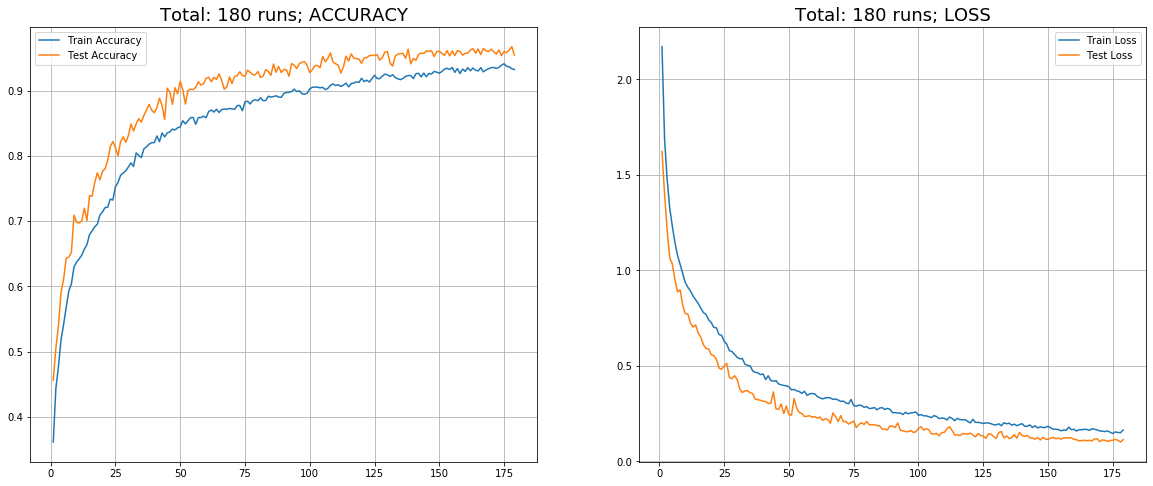

In [40]:
#22
def plot_acc_loss(history, epochs):
    acc = history.history['accuracy']
    loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    plt.figure(figsize=(20, 8))
    plt.subplot(121)
    plt.plot(range(1,epochs), acc[1:], label='Train Accuracy')
    plt.plot(range(1,epochs), val_acc[1:], label='Test Accuracy')
    plt.title('Total: ' + str(epochs) + ' runs; '+'ACCURACY', size=18)
    plt.legend()
    plt.grid(True)
    plt.subplot(122)
    plt.plot(range(1,epochs), loss[1:], label='Train Loss')
    plt.plot(range(1,epochs), val_loss[1:], label='Test Loss')
    plt.title('Total: ' + str(epochs) + ' runs; '+'LOSS', size=18)
    plt.legend()
    plt.grid(True)
    plt.show()
    
plot_acc_loss(history, 180)